# Temporal Co-Training

#### Team Details

| Name | SRN | Section
|:------|:-------: | :----: |
| Harshith Mohan Kumar | PES1UG19CS276|    E
| Vishruth Veerendranath | PES1UG19CS577 |    I
| Divya Shekar | PES1UG19CS148 |    C
| Vibha Masti | PES1UG19CS565 |    I

#### Instructions

##### Software Used
- pytorch version: 1.11.0+cu102
- numpy version: 1.21.6
- networkx version: 2.6.3
- pytorch geometric version: 2.0.4 
- pytorch geometric temporal version: 0.51.0 

#### Prior to running notebook


#### Note
- This notebook was created on [Deepnote](https://deepnote.com/workspace)
- A [Dockerfile](https://drive.google.com/file/d/121BRb5qTTCkgojAswX2BHWy6pAg3jmA4/view?usp=sharing) containing some of the dependencies
- A [requirements.txt](https://drive.google.com/file/d/1UwaQxbWx3rnLVoVj-5whY6QF4DObIUf8/view?usp=sharing) with additional dependencies
- The dataset used can be found [here](https://drive.google.com/drive/folders/10FOTa6HXPqX8Pf5WRoRwcFnW9BrNZEIX) - corresponding GitHub repo [here](https://github.com/liyaguang/DCRNN)

## References

1. [Traffic prediction using PyGT](https://colab.research.google.com/drive/132hNQ0voOtTVk3I4scbD3lgmPTQub0KR?usp=sharing#scrollTo=iOc-jbFckFHn)
2. [Corresponding video](https://www.youtube.com/watch?v=Rws9mf1aWUs&t=1s)
3. [Co-Training for Image Recognition](https://github.com/AlanChou/Deep-Co-Training-for-Semi-Supervised-Image-Recognition/blob/master/main.py)
4. [Co-Training for Sentiment Analysis](https://github.com/Deep-Co-Training/Deep-Co-Training)
5. [“GC-LSTM: Graph Convolution Embedded LSTM for Dynamic Link Prediction.”](https://arxiv.org/abs/1812.04206)
6. [“A3T-GCN: Attention Temporal Graph Convolutional Network for Traffic Forecasting.”](https://arxiv.org/abs/2006.11583)

## Description of the Project


Problem statement:

Scarcity of labelled data places a significant limitation on the power of any supervised machine learning model. This challenge is further amplified by the domain-specific expertise and hours of manual labour involved in labelling. In the case when even the available data is not enough, a strategy of **pesudo-labeling** using **semi-supervised learning** can be of help.

In this project we explore the following problems:

- Semi-supervised learning on static graphs with temporal 
- To perform traffic forecasting (node regression) using traffic readings contained in a static graph with temporal signals 
- To perform co-training using the following two views of the dataset:
    - Attention based GNN
    - LSTM GNN
- To compare the results from co-training with an equivalent supervised model



## Outline

1. Data Preperation
2. Supervised Learning
3. Co-Training (Semi-Supervised Learning)
4. Evaluation
5. Analysis

#### Imports

In [1]:
!pip3 install torch_geometric_temporal

     |████████████████████████████████| 48 kB 4.7 MB/s eta 0:00:011
     |████████████████████████████████| 1.9 MB 10.5 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 853 kB/s eta 0:00:01
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.52.0-py3-none-any.whl size=86194 sha256=5f04e4801e34016bb7feac924a5fc0b25ee592667f150f5cbd10758e90775a3f
  Stored in directory: /root/.cache/pip/wheels/0d/d6/0f/aa32cb28ec6e74ec3caf427e4835081d92c0fd72b7cdb4dd54
Successfully built torch-geometric-temporal
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [2]:
# Pytorch
import torch
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

# Standard
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Other
import random
from tqdm import tqdm
from tqdm import trange
import copy
import itertools
import os


In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
11.3
1
0
NVIDIA GeForce RTX 3080


In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Data Preperation
Approach:
1. Load dataset from [PyTorch Geometric Temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/index.html)
2. Split dataset into Train/Test (80% test data, 20% test data - we used a subset of the entire dataset due to RAM constraints)
3. Mask nodes within each timestep to form unlabeled data (70% of nodes unlabeled, 30% of nodes labeled)

### Data Ingestion
In this section we extract the [METR-LA](https://drive.google.com/drive/folders/10FOTa6HXPqX8Pf5WRoRwcFnW9BrNZEIX) static temporal signal graph using [torch geometric temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/_modules/torch_geometric_temporal/dataset/metr_la.html). We then split the dataset into `train`/`test` (part of `trunc`) and `rest` (discarded values as the dataset is too large to train on).


**Dataset description:**

A traffic forecasting dataset based on Los Angeles Metropolitan traffic conditions. The dataset contains traffic readings collected from 207 loop detectors on highways in Los Angeles County in aggregated 5 minute intervals for 4 months between March 2012 to June 2012.

For further details on the version of the sensor network and discretization see: [“Diffusion Convolutional Recurrent Neural Network: Data-Driven Traffic Forecasting”](https://arxiv.org/abs/1707.01926). The corresponding [GitHub](https://github.com/liyaguang/DCRNN) repository details the dataset and its representation.

It's crutial to understand that the *graph structure does not change over timeperiods in this temporal data, only the node "features/labels" do*.

NOTE: Any further reference to `timestep` would refer to an interval of 5 minutes



In [12]:
# Load the dataset from METRLA Pytorch Library
metrla_loader = METRLADatasetLoader()

# num_timesteps_in = 1 because in spatial view we input only one snapshot, to predict the next (num_timesteps_out = 1)
metrla_dataset = metrla_loader.get_dataset(num_timesteps_in=1, num_timesteps_out=1)

# Create data splits for train/test
train_dataset, rest_dataset = temporal_signal_split(metrla_dataset, train_ratio=0.8)
# train_dataset, test_dataset = temporal_signal_split(trunc_dataset, train_ratio=0.8)

In [13]:
#print("Size of trunc dataset (timesteps):",len(set(trunc_dataset)))
print("Size of train dataset (timesteps):",len(set(train_dataset)))
#print("Size of test dataset (timesteps):",len(set(test_dataset)))

Size of train dataset (timesteps): 27416


### Graph Visualization


In [14]:
def plot_graph(G, layout=nx.spring_layout, node_size=800, font_size=8, node_color='lightgreen'):
    """
    Plot a networkx graph
    """

    plt.figure(figsize=(15, 15))
    pos = layout(G)

    nx.draw_networkx(G, pos=pos, node_size=node_size, font_size=font_size, node_color=node_color)
    nx.draw_networkx_edges(G, pos=pos)
    
    # edge_labels = nx.get_edge_attributes(G, 'Weight')
    # nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
    plt.show()

### Masking a random subset of nodes

To perform **Semi-Supervised Learning** on the METR-LA Dataset which is fully labelled, we **mask the labels of a certain percentage of nodes** (70%). The nodes that are masked are picked randomly. Masking is performed by setting the label values to `NaN` across all timesteps.

This would be anologous to the failure of a certain percentage of sensors on the highway. 

In [15]:
# Number of nodes
nodes = list(train_dataset)[-1].num_nodes

# Unlabelled fraction
u_fraction = 0.7
random.seed(42)

# Range of numbers from 0 to 206 (number of nodes)
all_nodes = np.arange(nodes)

# Masking random sample of nodes with NaN
masked_nodes = np.array(random.sample(range(nodes), int(u_fraction*nodes)))

# Indices of true labelled nodes
non_masked = np.setdiff1d(all_nodes, masked_nodes)

# Print shape of all nodes, unlabelled and labelled nodes
print(all_nodes.shape, masked_nodes.shape, non_masked.shape)

# Create semi-supervised training dataset
data_semi = copy.deepcopy(train_dataset)

# Graph edges for the last timestep
edge_index = list(train_dataset)[-1].edge_index

(207,) (144,) (63,)


In [16]:
masked_nodes

array([163,  28,   6, 189,  70,  62,  57,  35, 188,  26, 173, 203, 139,
        22, 151, 108,   8,   7,  23,  55,  59, 129, 154, 204, 143,  50,
       166, 179, 194, 107,  56, 114, 150,  71,   1,  40, 191,  87, 196,
        39, 187,  86, 197, 198,  97,  24,  91,  88, 184,  67,  11, 117,
       137,  31,  96,  20, 141,  75,  92, 147,  49,  17, 156,  58,  74,
       192, 186,  25, 162, 168, 116,  93,  41,  94,  90,  53,  68,  18,
        43, 201, 174, 140,  48,  34, 118,  81, 159, 158, 205, 169, 134,
       177,  98,  99, 195,  29, 105,   4, 103, 171,  51, 123, 190,  27,
        72, 160, 115, 170,  83,  63, 181,  82, 182, 185,  33, 145, 153,
       119, 130, 148, 142,  54, 165, 106,  46, 122, 101,  65, 138, 144,
       183,  14,  19, 126,  85, 104, 146, 124, 125, 157,  32, 172, 149,
       110])

In [17]:
# Replace masked node labels with np.nan in train_semi
for snapshot in data_semi:
    snapshot.y[masked_nodes] = np.nan

In [18]:
# Labels of nodes in the last timestep
list(data_semi)[-1].y

tensor([[ 0.4926],
        [    nan],
        [ 0.7125],
        [ 0.3057],
        [    nan],
        [-0.1836],
        [    nan],
        [    nan],
        [    nan],
        [ 0.6960],
        [-0.4035],
        [    nan],
        [ 0.4706],
        [ 0.2342],
        [    nan],
        [ 0.5641],
        [-0.8983],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [ 0.2122],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [-0.0297],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [ 0.6356],
        [ 0.5806],
        [ 0.3785],
        [    nan],
        [    nan],
        [    nan],
        [ 0.4651],
        [    nan],
        [ 0.4486],
        [ 0.6356],
        [    nan],
        [ 0.4321],
        [    nan],
        [    nan],
        [    nan],
        [    nan],
        [ 0.

In [19]:
# X values for the first timestep
data_semi[0].x[masked_nodes]

tensor([[[ 7.8058e-01],
         [-1.7292e+00]],

        [[ 6.5687e-01],
         [-1.7292e+00]],

        [[ 5.7028e-01],
         [-1.7292e+00]],

        [[ 8.0532e-01],
         [-1.7292e+00]],

        [[ 4.7132e-01],
         [-1.7292e+00]],

        [[-5.4413e-02],
         [-1.7292e+00]],

        [[ 3.2906e-01],
         [-1.7292e+00]],

        [[ 4.1565e-01],
         [-1.7292e+00]],

        [[ 6.5687e-01],
         [-1.7292e+00]],

        [[ 3.7854e-01],
         [-1.7292e+00]],

        [[ 5.0225e-01],
         [-1.7292e+00]],

        [[ 7.6202e-01],
         [-1.7292e+00]],

        [[ 4.9606e-01],
         [-1.7292e+00]],

        [[ 5.0734e-02],
         [-1.7292e+00]],

        [[-2.3487e-02],
         [-1.7292e+00]],

        [[ 4.9606e-01],
         [-1.7292e+00]],

        [[ 2.9814e-01],
         [-1.7292e+00]],

        [[ 6.6924e-01],
         [-1.7292e+00]],

        [[ 2.2392e-01],
         [-1.7292e+00]],

        [[ 3.4143e-01],
         [-1.7292e+00]],



In [20]:
# Last timestep semi-supervised data
list(data_semi)[-1]

Data(x=[207, 2, 1], edge_index=[2, 1722], edge_attr=[1722], y=[207, 1])

In [21]:
# Calcualte the number of timesteps to be used as batches during training
total_timesteps = len(list(data_semi)) + 1

## Supervised Learning


### Model Initialization

For our two models, we have used one Attention based GNN and the other being a LSTM GNN. The reason behind the choice of these two models is the difference in their respective data processing techniques. The LSTM model places higher weightage on the most recent timesteps (linear processing) while the Attention based model distributes this emphasis across different timesteps (non-linear processing). It is our belief that this qualifies the implementation in terms of the conditional independence of two views required by the co-training algorithm. 

In this section we define the architecture for both of these models which is suitable with static temporal signals.

We have used the Adam optimizer for both GNN models defined.

#### GCLSTM
An implementation of the the Integrated Graph Convolutional Long Short Term Memory Cell. For details see this paper: [“GC-LSTM: Graph Convolution Embedded LSTM for Dynamic Link Prediction.”](https://arxiv.org/abs/1812.04206)

In [22]:
from torch_geometric_temporal.nn.recurrent import A3TGCN, GCLSTM

class LSTMGNN(torch.nn.Module):
    def __init__(self, model_class, node_features, out_channels, **kwargs):
        # kwargs for GCLSTM : {K: K} -> Chebyshev filter order
        periods = kwargs.get('periods', 1)
        K = kwargs.get('K', 1)
        super(LSTMGNN, self).__init__()

        # Attention Temporal Graph Convolutional Cell
        self.tgnn = model_class(in_channels=node_features, 
                           out_channels=out_channels, 
                           **kwargs)
    
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(out_channels, 1)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h, c = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

# model1 = LSTMGNN(GCLSTM, node_features=2, out_channels=nodes, K=2)
# optimizer1 = torch.optim.Adam(params=model1.parameters(), lr = 0.01)

#### A3TGCN
An implementation of the Attention Temporal Graph Convolutional Cell. For details see this paper: [“A3T-GCN: Attention Temporal Graph Convolutional Network for Traffic Forecasting.”](https://arxiv.org/abs/2006.11583)

In [23]:
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN, GCLSTM
from torch.nn import MSELoss

class AttentionGNN(torch.nn.Module):
    def __init__(self, model_class, node_features, out_channels, **kwargs):
        # kwargs for A3TGCN : {periods=periods}
        # kwargs for GCLSTM : {K: K} -> Chebyshev filter order
        periods = kwargs.get('periods', 1)
        K = kwargs.get('K', 1)
        super(AttentionGNN, self).__init__()

        # Attention Temporal Graph Convolutional Cell
        self.tgnn = model_class(in_channels=node_features, 
                           out_channels=out_channels, 
                           **kwargs)
    
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(out_channels, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

# model2 = AttentionGNN(A3TGCN, node_features=2, periods=1, out_channels=nodes)
# optimizer2 = torch.optim.Adam(params=model2.parameters(), lr = 0.01)

### Training

In [17]:
def train_super_helper(epoch, model, optimizer, data_semi, non_masked, reshape=False):
    '''
    Helper method to train the supervised model.
    '''
    model.train()
    loss = MSELoss()
    
    # Tensor of size : (number of timesteps in data, )
    loss_total = torch.zeros(len(list(data_semi))).to(device)

    for timestep, snapshot in enumerate(data_semi):
        if timestep % 10 == 0:
            print(timestep)
        
        # Load data to gpu
        snapshot.x = snapshot.x.to(device)
        snapshot.y = snapshot.y.to(device)
        snapshot.edge_index = snapshot.edge_index.to(device)
        
        # Forward passes for a timestep
        if reshape:
            yhat = model.forward(snapshot.x.reshape(-1, 2), snapshot.edge_index).reshape(-1)
        else:
            yhat = model.forward(snapshot.x, snapshot.edge_index).reshape(-1)
        
        # Individual model losses for that timestep (only for labelled data)
        loss_model = loss(yhat[non_masked], snapshot.y.reshape(-1)[non_masked])
        
        loss_total[timestep] = loss_model.item()

        optimizer.zero_grad()

        loss_model.backward()

        optimizer.step()
    
    
    print(f'Train MSE for {epoch}:', torch.sum(loss_total))
    return torch.sum(loss_total)

@torch.no_grad()
def test_super(model, data_labelled, reshape):
    '''
    Method to evaluate the supervised model.
    '''
    model.eval()
    loss = MSELoss()
    
    loss_total = torch.zeros(len(list(data_labelled))).to(device)

    for timestep, snapshot in enumerate(data_labelled):
        
        # Load data to gpu
        snapshot.x = snapshot.x.to(device)
        snapshot.y = snapshot.y.to(device)
        snapshot.edge_index = snapshot.edge_index.to(device)
        
        # Forward passes for a timestep
        if reshape:
            yhat = model.forward(snapshot.x.reshape(-1, 2), snapshot.edge_index).reshape(-1)
        else:
            yhat = model.forward(snapshot.x, snapshot.edge_index).reshape(-1)

        
        loss_model = loss(yhat, snapshot.y.reshape(-1))
        loss_total[timestep] = loss_model.item()
    

    print('Test MSE:', torch.sum(loss_total))
    return torch.sum(loss_total)

In [18]:
def train_super(epochs, model, optimizer, data_semi, data_labelled, non_masked, reshape=False):
    '''
    Method for training the supervised model.
        Args:
            epochs: Number of epochs to train
            model: Temporal Signal model
            optimizer: Optimizer for corresponding model
            data_semi: Masked training dataset
            data_labelled: Non-masked training dataset
            non_masked: Non-masked indices
            reshape: bool for ATTN model
    '''
    # Losses for all epochs
    train_loss = np.empty((0))

    # Train the model
    for epoch in trange(epochs):
        # Single loss value (float) for every epoch
        loss_epoch = train_super_helper(epoch, model, optimizer, data_semi, non_masked, reshape)
        
        # Append the loss
        train_loss = np.append(train_loss, loss_epoch.cpu().detach().numpy())

    # Test the model on the labelled dataset
    test_loss = test_super(model, data_labelled, reshape)
    return train_loss, test_loss

In [19]:
# Train LSTM model using supervised learning
epochs = 30
model_lstm_super = LSTMGNN(GCLSTM, node_features=2, out_channels=nodes, K=2)
optimizer_lstm_super = torch.optim.Adam(params=model_lstm_super.parameters(), lr = 0.01)
data_labelled = train_dataset

In [20]:
# Load Model to GPU
model_lstm_super.to(device)

LSTMGNN(
  (tgnn): GCLSTM(
    (conv_i): ChebConv(207, 207, K=2, normalization=sym)
    (conv_f): ChebConv(207, 207, K=2, normalization=sym)
    (conv_c): ChebConv(207, 207, K=2, normalization=sym)
    (conv_o): ChebConv(207, 207, K=2, normalization=sym)
  )
  (linear): Linear(in_features=207, out_features=1, bias=True)
)

In [21]:
train_loss_super_lstm, test_loss_super_lstm = train_super(epochs, model_lstm_super, optimizer_lstm_super, data_semi, data_labelled, non_masked, reshape=True)

print(f'Train loss for LSTM: {train_loss_super_lstm}')
print(f'Test loss for LSTM: {test_loss_super_lstm}')


  0%|                                                                  | 0/30 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
1719

  3%|█▊                                                     | 1/30 [02:24<1:09:49, 144.47s/it]

27390
27400
27410
Train MSE for 0: tensor(2976.0784, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2

15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
1705

  7%|███▋                                                   | 2/30 [04:45<1:06:25, 142.33s/it]

27400
27410
Train MSE for 1: tensor(2914.3091, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
20

15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
1706

 10%|█████▌                                                 | 3/30 [07:06<1:03:44, 141.65s/it]

27410
Train MSE for 2: tensor(2891.4729, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
210

15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
1709

 13%|███████▎                                               | 4/30 [09:27<1:01:24, 141.72s/it]

27390
27400
27410
Train MSE for 3: tensor(2883.1631, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 17%|█████████▌                                               | 5/30 [11:49<59:01, 141.65s/it]

27400
27410
Train MSE for 4: tensor(2881.1802, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
20

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 20%|███████████▍                                             | 6/30 [14:10<56:35, 141.48s/it]

27410
Train MSE for 5: tensor(2880.4392, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
210

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 23%|█████████████▎                                           | 7/30 [16:31<54:09, 141.30s/it]

27400
27410
Train MSE for 6: tensor(2880.5872, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
20

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 27%|███████████████▏                                         | 8/30 [18:51<51:39, 140.88s/it]

27400
27410
Train MSE for 7: tensor(2878.9800, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
20

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 30%|█████████████████                                        | 9/30 [21:11<49:14, 140.67s/it]

27390
27400
27410
Train MSE for 8: tensor(2876.9146, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2

15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
1706

 33%|██████████████████▋                                     | 10/30 [23:32<46:56, 140.81s/it]

27390
27400
27410
Train MSE for 9: tensor(2876.7126, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2

15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
1705

 37%|████████████████████▌                                   | 11/30 [25:54<44:39, 141.00s/it]

27410
Train MSE for 10: tensor(2877.9814, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 40%|██████████████████████▍                                 | 12/30 [28:15<42:18, 141.00s/it]

27390
27400
27410
Train MSE for 11: tensor(2876.6213, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070


15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
1706

 43%|████████████████████████▎                               | 13/30 [30:35<39:54, 140.88s/it]

27390
27400
27410
Train MSE for 12: tensor(2877.7056, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070


15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
1705

 47%|██████████████████████████▏                             | 14/30 [32:57<37:36, 141.04s/it]

27390
27400
27410
Train MSE for 13: tensor(2876.5078, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070


15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
1706

 50%|████████████████████████████                            | 15/30 [35:18<35:16, 141.07s/it]

27410
Train MSE for 14: tensor(2877.3994, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
1709

 53%|█████████████████████████████▊                          | 16/30 [37:40<32:57, 141.29s/it]

27380
27390
27400
27410
Train MSE for 15: tensor(2876.0547, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 57%|███████████████████████████████▋                        | 17/30 [40:01<30:36, 141.28s/it]

27400
27410
Train MSE for 16: tensor(2876.0259, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2

15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
1706

 60%|█████████████████████████████████▌                      | 18/30 [42:23<28:17, 141.48s/it]

27380
27390
27400
27410
Train MSE for 17: tensor(2877.2185, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060

15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
1705

 63%|███████████████████████████████████▍                    | 19/30 [44:45<25:57, 141.63s/it]

27390
27400
27410
Train MSE for 18: tensor(2877.2620, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070


15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
1706

 67%|█████████████████████████████████████▎                  | 20/30 [47:07<23:36, 141.67s/it]

27380
27390
27400
27410
Train MSE for 19: tensor(2875.8083, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060

15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
1704

 70%|███████████████████████████████████████▏                | 21/30 [49:29<21:16, 141.81s/it]

27400
27410
Train MSE for 20: tensor(2875.8857, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2

15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
1709

 73%|█████████████████████████████████████████               | 22/30 [51:50<18:51, 141.47s/it]

27400
27410
Train MSE for 21: tensor(2875.7773, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 77%|██████████████████████████████████████████▉             | 23/30 [54:11<16:30, 141.50s/it]

27410
Train MSE for 22: tensor(2876.1235, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
1709

 80%|████████████████████████████████████████████▊           | 24/30 [56:32<14:07, 141.31s/it]

27380
27390
27400
27410
Train MSE for 23: tensor(2876.3533, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060

15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
1705

 83%|██████████████████████████████████████████████▋         | 25/30 [58:53<11:46, 141.29s/it]

27380
27390
27400
27410
Train MSE for 24: tensor(2874.9634, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060

15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
1704

 87%|██████████████████████████████████████████████▊       | 26/30 [1:01:15<09:25, 141.43s/it]

27410
Train MSE for 25: tensor(2875.6377, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
1710

 90%|████████████████████████████████████████████████▌     | 27/30 [1:03:37<07:04, 141.47s/it]

27390
27400
27410
Train MSE for 26: tensor(2875.2480, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070


15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 93%|██████████████████████████████████████████████████▍   | 28/30 [1:05:58<04:42, 141.36s/it]

27410
Train MSE for 27: tensor(2875.1965, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
1710

 97%|████████████████████████████████████████████████████▏ | 29/30 [1:08:19<02:21, 141.31s/it]

Train MSE for 28: tensor(2875.0566, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
211

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

100%|██████████████████████████████████████████████████████| 30/30 [1:10:41<00:00, 141.40s/it]

27390
27400
27410
Train MSE for 29: tensor(2874.8091, device='cuda:0')


Test MSE: tensor(3060.3823, device='cuda:0')
Train loss for LSTM: [2976.07836914 2914.30908203 2891.47290039 2883.16308594 2881.18017578
 2880.43920898 2880.5871582  2878.97998047 2876.91455078 2876.71264648
 2877.98144531 2876.62133789 2877.70556641 2876.5078125  2877.39941406
 2876.0546875  2876.02587891 2877.21850586 2877.26196289 2875.80834961
 2875.88574219 2875.77734375 2876.12353516 2876.35327148 2874.96337891
 2875.63769531 2875.24804688 2875.1965332  2875.05664062 2874.80908203]
Test loss for LSTM: 3060.38232421875


In [22]:
# Train Attention model using supervised learning
model_attn_super = AttentionGNN(A3TGCN, node_features=2, periods=1, out_channels=nodes)
optimizer_attn_super = torch.optim.Adam(params=model_attn_super.parameters(), lr = 0.01)
# train_data = train_dataset

In [23]:
model_attn_super.to(device)

AttentionGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 207)
      (linear_z): Linear(in_features=414, out_features=207, bias=True)
      (conv_r): GCNConv(2, 207)
      (linear_r): Linear(in_features=414, out_features=207, bias=True)
      (conv_h): GCNConv(2, 207)
      (linear_h): Linear(in_features=414, out_features=207, bias=True)
    )
  )
  (linear): Linear(in_features=207, out_features=1, bias=True)
)

In [24]:
train_loss_super_attn, test_loss_super_attn = train_super(epochs, model_attn_super, optimizer_attn_super, data_semi, data_labelled, non_masked, reshape=False)

print(f'Train loss for Attn: {train_loss_super_attn}')
print(f'Test loss for Attn: {test_loss_super_attn}')


  0%|                                                                  | 0/30 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
1717

  3%|█▉                                                       | 1/30 [01:45<50:57, 105.44s/it]

27400
27410
Train MSE for 0: tensor(10580.8906, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2

15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
1711

  7%|███▊                                                     | 2/30 [03:30<49:08, 105.30s/it]

27410
Train MSE for 1: tensor(10762.3955, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 10%|█████▋                                                   | 3/30 [05:16<47:28, 105.48s/it]

27380
27390
27400
27410
Train MSE for 2: tensor(10558.4590, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 13%|███████▌                                                 | 4/30 [07:01<45:36, 105.27s/it]

Train MSE for 3: tensor(10769.7734, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
211

15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
1710

 17%|█████████▌                                               | 5/30 [08:46<43:49, 105.17s/it]

Train MSE for 4: tensor(10863.2148, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
211

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 20%|███████████▍                                             | 6/30 [10:31<42:02, 105.11s/it]

27410
Train MSE for 5: tensor(11102.4902, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
1712

 23%|█████████████▎                                           | 7/30 [12:16<40:18, 105.16s/it]

27390
27400
27410
Train MSE for 6: tensor(11449.8789, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070


15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
1709

 27%|███████████████▏                                         | 8/30 [14:01<38:34, 105.20s/it]

27410
Train MSE for 7: tensor(11483.3955, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 30%|█████████████████                                        | 9/30 [15:47<36:49, 105.24s/it]

27410
Train MSE for 8: tensor(11573.9482, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
21

15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
1712

 33%|██████████████████▋                                     | 10/30 [17:32<35:05, 105.25s/it]

27370
27380
27390
27400
27410
Train MSE for 9: tensor(11839.7734, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
205

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 37%|████████████████████▌                                   | 11/30 [19:17<33:18, 105.19s/it]

27390
27400
27410
Train MSE for 10: tensor(11815.5234, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 40%|██████████████████████▍                                 | 12/30 [21:02<31:33, 105.22s/it]

27410
Train MSE for 11: tensor(11503.6836, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 43%|████████████████████████▎                               | 13/30 [22:48<29:51, 105.40s/it]

27380
27390
27400
27410
Train MSE for 12: tensor(11513.4297, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
206

15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
1709

 47%|██████████████████████████▏                             | 14/30 [24:34<28:06, 105.42s/it]

27380
27390
27400
27410
Train MSE for 13: tensor(11452.6172, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
206

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 50%|████████████████████████████                            | 15/30 [26:18<26:19, 105.28s/it]

27410
Train MSE for 14: tensor(11525.9902, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2

15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
1710

 53%|█████████████████████████████▊                          | 16/30 [28:04<24:34, 105.30s/it]

27370
27380
27390
27400
27410
Train MSE for 15: tensor(11428.7109, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
20

15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
1704

 57%|███████████████████████████████▋                        | 17/30 [29:49<22:47, 105.21s/it]

27370
27380
27390
27400
27410
Train MSE for 16: tensor(11311.8184, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
20

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 60%|█████████████████████████████████▌                      | 18/30 [31:34<21:02, 105.19s/it]

27400
27410
Train MSE for 17: tensor(11282.7129, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080


15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 63%|███████████████████████████████████▍                    | 19/30 [33:20<19:20, 105.51s/it]

27410
Train MSE for 18: tensor(11506.7695, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 67%|█████████████████████████████████████▎                  | 20/30 [35:06<17:36, 105.68s/it]

27390
27400
27410
Train MSE for 19: tensor(11248.5928, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070

15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
1710

 70%|███████████████████████████████████████▏                | 21/30 [36:52<15:51, 105.76s/it]

27410
Train MSE for 20: tensor(11355.4883, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 73%|█████████████████████████████████████████               | 22/30 [38:38<14:06, 105.84s/it]

Train MSE for 21: tensor(11164.3721, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
21

15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
1710

 77%|██████████████████████████████████████████▉             | 23/30 [40:24<12:20, 105.80s/it]

27390
27400
27410
Train MSE for 22: tensor(11102.8672, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 80%|████████████████████████████████████████████▊           | 24/30 [42:10<10:34, 105.82s/it]

27380
27390
27400
27410
Train MSE for 23: tensor(11173.3203, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
206

15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
1707

 83%|██████████████████████████████████████████████▋         | 25/30 [43:55<08:48, 105.72s/it]

27380
27390
27400
27410
Train MSE for 24: tensor(11192.6377, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
206

15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
1705

 87%|████████████████████████████████████████████████▌       | 26/30 [45:41<07:02, 105.58s/it]

27400
27410
Train MSE for 25: tensor(11353.1816, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080


15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
1710

 90%|██████████████████████████████████████████████████▍     | 27/30 [47:26<05:16, 105.59s/it]

27400
27410
Train MSE for 26: tensor(11489.7539, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080


15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
1706

 93%|████████████████████████████████████████████████████▎   | 28/30 [49:11<03:30, 105.37s/it]

27410
Train MSE for 27: tensor(11683.2598, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2

15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
1708

 97%|██████████████████████████████████████████████████████▏ | 29/30 [50:56<01:45, 105.17s/it]

27400
27410
Train MSE for 28: tensor(11341.2168, device='cuda:0')
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080


15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
1709

100%|████████████████████████████████████████████████████████| 30/30 [52:41<00:00, 105.38s/it]

27370
27380
27390
27400
27410
Train MSE for 29: tensor(11291.0254, device='cuda:0')


Test MSE: tensor(20618.3203, device='cuda:0')
Train loss for Attn: [10580.890625   10762.39550781 10558.45898438 10769.7734375
 10863.21484375 11102.49023438 11449.87890625 11483.39550781
 11573.94824219 11839.7734375  11815.5234375  11503.68359375
 11513.4296875  11452.6171875  11525.99023438 11428.7109375
 11311.81835938 11282.71289062 11506.76953125 11248.59277344
 11355.48828125 11164.37207031 11102.8671875  11173.3203125
 11192.63769531 11353.18164062 11489.75390625 11683.25976562
 11341.21679688 11291.02539062]
Test loss for Attn: 20618.3203125


### Results

Here are the results from supervised learning on the non-masked dataset:

| Model |   MSE |
| ----- | -------: |
| LSTM Based | 0.324 |
| Attention Based | 0.370 |

**Note: These values are subject to change upon rerunning the notebook

## Co-Training (Semi-Supervised)

[Co-training](https://www.cs.cmu.edu/~avrim/Papers/cotrain.pdf) is a **semi-supervised learning technique** which trains two classifiers based on two different views of data. It was originally proposed by Tom Mitchell and Avrim Blum, two iconic figures from CMU. In this project we have adapted the algorithm to run on static temporal graph networks. 

Our custom algorithm:
1. Create dataset which consists of pools of labeled and unlabeled data (proportion of unlabeled data is much higher)
2. Feed the data into the two GNN models which function as two views of the data (such that the two models can learn different features off of each other)
3. Calculate the absolute difference between the predictions (traffic speed) obtained by the two models and pick the most similar predictions as the top-k most confident pseudo labels (intuition being that the predictions which are consistent across both models are more likely to be accurate)
4. Append the pseudo labels to the pool of labeled data. This way, the amount of labeled data increases across each iteration
5. Continue until all unlabeled data has been converted to labeled data 
6. Final predictions are a simple average of the predictions of the two models

In [25]:
masked_nodes

array([163,  28,   6, 189,  70,  62,  57,  35, 188,  26, 173, 203, 139,
        22, 151, 108,   8,   7,  23,  55,  59, 129, 154, 204, 143,  50,
       166, 179, 194, 107,  56, 114, 150,  71,   1,  40, 191,  87, 196,
        39, 187,  86, 197, 198,  97,  24,  91,  88, 184,  67,  11, 117,
       137,  31,  96,  20, 141,  75,  92, 147,  49,  17, 156,  58,  74,
       192, 186,  25, 162, 168, 116,  93,  41,  94,  90,  53,  68,  18,
        43, 201, 174, 140,  48,  34, 118,  81, 159, 158, 205, 169, 134,
       177,  98,  99, 195,  29, 105,   4, 103, 171,  51, 123, 190,  27,
        72, 160, 115, 170,  83,  63, 181,  82, 182, 185,  33, 145, 153,
       119, 130, 148, 142,  54, 165, 106,  46, 122, 101,  65, 138, 144,
       183,  14,  19, 126,  85, 104, 146, 124, 125, 157,  32, 172, 149,
       110])

In [26]:
non_masked

array([  0,   2,   3,   5,   9,  10,  12,  13,  15,  16,  21,  30,  36,
        37,  38,  42,  44,  45,  47,  52,  60,  61,  64,  66,  69,  73,
        76,  77,  78,  79,  80,  84,  89,  95, 100, 102, 109, 111, 112,
       113, 120, 121, 127, 128, 131, 132, 133, 135, 136, 152, 155, 161,
       164, 167, 175, 176, 178, 180, 193, 199, 200, 202, 206])

### Helper Methods

In [27]:
# Function to append pseudo labels to the pool of labeled data the model is trained on at the end of every iteration
def append_top_k(data, pseudo1, pseudo2, non_masked, masked_nodes, top_k_indices):
    '''
    Args:
        data: Pytorch Temporal Signal Object
        top_k: Dictonary where keys = node_index and value = [pseudo_label for all timesteps]
    Returns:
        data_appended: Pytorch Temporal Signal Object with the top_k values
    '''
    # global non_masked
    # global masked_nodes
    # Replace masked node labels with predicted values of epoch

    print('Check', pseudo1.shape, pseudo2.shape)

    avg = torch.div(torch.add(pseudo1, pseudo2), 2)
    avg_selected = avg[:, top_k_indices]

    print('Avg', avg_selected.shape)

    for i, snapshot in enumerate(data):
        snapshot.y[top_k_indices] = avg_selected[i].reshape(-1,1)
    
    # non_masked = np.array(torch.cat((torch.tensor(non_masked), top_k_indices)))
    # Update non_masked and masked after adding topk 
    print('Before', non_masked.shape, masked_nodes.shape)
    non_masked = np.concatenate((non_masked, np.array(top_k_indices)))
    masked_nodes = np.setdiff1d(all_nodes, non_masked)
    print('After', non_masked.shape, masked_nodes.shape, '\n')

    return data, non_masked, masked_nodes

In [28]:
# Import library for progress bar - using tensors - too much ram - OLD works for model1
# Helper Train method
def train_single_model(epoch, model, optimizer, data_semi, k, non_masked, reshape=False):
    # Train the two models
    # global non_masked
    model.train()

    loss = MSELoss()

#    yhat_total = torch.zeros((total_timesteps, nodes))
    loss_total = torch.zeros(len(list(data_semi))).to(device)

    # Print log and statistics for epoch:
    print()
    print("="*20)
    print('epoch:',epoch+1)

    for timestep, snapshot in enumerate(data_semi):
        
        # Load data to gpu
        snapshot.x = snapshot.x.to(device)
        snapshot.y=snapshot.y.to(device)
        snapshot.edge_index=snapshot.edge_index.to(device)
        
        if timestep % 10 == 0:
            print(timestep)

        # Forward passes for a timestep
        if reshape:
            yhat = model.forward(snapshot.x.reshape(-1, 2), snapshot.edge_index).reshape(-1)
        else:
            yhat = model.forward(snapshot.x, snapshot.edge_index).reshape(-1)
        
        # Individual model losses for that timestep (only for labelled data)
        loss_model = loss(yhat[non_masked], snapshot.y.reshape(-1)[non_masked])
        

        optimizer.zero_grad()
        loss_model.backward()
        optimizer.step()

        # yhat_total[timestep+1,:] = yhat
        loss_total[timestep] = loss_model.item()
    
    print(f'Train MSE for epoch {epoch}:', torch.sum(loss_total))

    return torch.sum(loss_total)


@torch.no_grad()
# def test(epoch, model, data, non_masked, reshape=False):
def test_semi_single(epoch, model, data_labelled, reshape=False):
    # Put the model into Eval mode
    model.eval()
    loss = MSELoss()
    loss_total = torch.zeros(len(list(data_labelled))).to(device)

    # Generate Predictions
    for timestep, snapshot in enumerate(data_labelled):
        
        # Load data to gpu
        snapshot.x = snapshot.x.to(device)
        snapshot.y=snapshot.y.to(device)
        snapshot.edge_index=snapshot.edge_index.to(device)
        
        # Forward passes for a timestep
        if reshape:
            yhat = model.forward(snapshot.x.reshape(-1, 2), snapshot.edge_index).reshape(-1)
        else:
            yhat = model.forward(snapshot.x, snapshot.edge_index).reshape(-1)

    
        # loss_model = loss(yhat[non_masked], snapshot.y.reshape(-1)[non_masked])
        loss_model = loss(yhat, snapshot.y.reshape(-1))
        
        loss_total[timestep]=loss_model.item()
        
        
    # print('Testing epoch:', epoch)
    print(f'Test MSE for {epoch}:', torch.sum(loss_total))
    return torch.sum(loss_total)
    #TODO: Generate MSE and print

In [29]:
@torch.no_grad()
def pseudo_labels(model, data_semi, reshape=False):
    '''
    Method to calculate the pseudo labels after one epoch of training.
    Args:
        model: Trained temporal model
        data_semi: Unlabelled dataset
        reshape:
    Return:
        yhat_total: Tensor with all the y outputs for the Temporal Signal Series
    '''

    yhat_total = torch.zeros((len(list(data_semi)), nodes))
    
    # Put the model into Eval mode
    model.eval()

    # Generate Predictions
    for timestep, snapshot in enumerate(data_semi):
        
        # Load data to gpu
        snapshot.x = snapshot.x.to(device)
        snapshot.y=snapshot.y.to(device)
        snapshot.edge_index=snapshot.edge_index.to(device)
        
        # Forward passes for a timestep
        if reshape:
            yhat = model.forward(snapshot.x.reshape(-1, 2), snapshot.edge_index).reshape(-1)
        else:
            yhat = model.forward(snapshot.x, snapshot.edge_index).reshape(-1)
            
        #yhat_total[timestep+1,:] = yhat
        yhat_total[timestep,:] = yhat
        
    return yhat_total

In [30]:
#picking the top-k most confident predictions as pseudo labels 
@torch.no_grad()
def top_k(pred1, pred2, non_masked, masked_nodes, k):
    
    '''
    y_pred1, y_pred2 : Dictionary with node index as key and predicted value as value
    k : Number of predictions to pick as pseudolabels

    Returns dictionary of top-k node labels node labels and corresponding mean values of the predictions
    '''
    # global non_masked
    diff = torch.abs(torch.sub(pred1, pred2)).sum(dim = 0)
    print('Diff', diff.shape)

    # Set the diff of the non masked (labeled) nodes to be 
    # infinity, so that they are not picked ni the top k
    diff[non_masked] = float('inf')
    print('Diff Masked', diff.shape)

    # TODO: make sure that the topk do not contain 'inf' in 
    # later epochs (Check if this works)
    k = min(masked_nodes.shape[0], k)

    topk_res = torch.topk(diff, k, largest=False)
    # print(topk_res)

    return topk_res.indices

In [31]:
masked_nodes.shape[0]

144

In [32]:
non_masked.shape

(63,)

In [33]:
# Before training
torch.isnan(data_semi[-1].y).sum()

tensor(144)

### Training

**Warning**: This method takes atleast an hour to train. So fire it up, grab some popcorn, go watch a tv show and come back :)

In [34]:
t = np.empty((10,2,2))
t

array([[[4.65988543e-310, 0.00000000e+000],
        [0.00000000e+000, 2.12199579e-314]],

       [[2.12199579e-314, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000]],

       [[4.24399158e-314, 2.12199579e-314],
        [0.00000000e+000, 0.00000000e+000]],

       [[0.00000000e+000, 6.36598737e-314],
        [2.12199579e-314, 0.00000000e+000]],

       [[0.00000000e+000, 0.00000000e+000],
        [8.48798316e-314, 2.12199579e-314]],

       [[0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 1.06099790e-313]],

       [[2.12199579e-314, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000]],

       [[1.27319747e-313, 2.12199579e-314],
        [0.00000000e+000, 0.00000000e+000]],

       [[0.00000000e+000, 1.48539705e-313],
        [2.12199579e-314, 0.00000000e+000]],

       [[0.00000000e+000, 0.00000000e+000],
        [            nan, 2.12199579e-314]]])

In [35]:
t = np.append(t, [[32],[23]])
t

array([4.65988543e-310, 0.00000000e+000, 0.00000000e+000, 2.12199579e-314,
       2.12199579e-314, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       4.24399158e-314, 2.12199579e-314, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 6.36598737e-314, 2.12199579e-314, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 8.48798316e-314, 2.12199579e-314,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.06099790e-313,
       2.12199579e-314, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       1.27319747e-313, 2.12199579e-314, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 1.48539705e-313, 2.12199579e-314, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000,             nan, 2.12199579e-314,
       3.20000000e+001, 2.30000000e+001])

In [36]:
np.empty((0,1))

array([], shape=(0, 1), dtype=float64)

In [37]:
# Custom train method built for co-training with two models

def co_train(epochs, data_semi, data_labelled, model_lstm, model_attn, optimizer_lstm, optimizer_attn, non_masked, masked_nodes, k):
    '''
    Args:
        train_semi: StaticGraphTemporalSignal
        model_1: Temporal model
        model_2: Temporal attention based model
        optimizer_1: Optimizer for Temporal
        optimizer_2: Optimizer for Attention 
        k: Number of masked nodes pseudolabels to append in each epoch
    '''
    train_loss_total_lstm = np.empty((0,1))
    train_loss_total_attn = np.empty((0,1))
    
    #test_pseudo_lstm_total = np.empty((0,1))
    #test_pseudo_attn_total = np.empty((0,1))
    test_lstm_total = np.empty((0,1))
    test_attn_total = np.empty((0,1))
    

    for epoch in trange(epochs):
        print('\nnon masked:', masked_nodes.size)
        #k = min(k, masked_nodes.size)
        
        print('k:', k)
        
        
        
        # Train and obtain top_k pseudo labels
        print('LSTM Model:')
        train_loss_lstm = train_single_model(epoch, model_lstm, optimizer_lstm, data_semi, k, non_masked, reshape=True)
        
        # CHECK DATA_SEMI SIZE
        #print(f'DATA SEMI SIZE FOR VV: {data_semi}')
        
        print('Attention Model:')
        train_loss_attn = train_single_model(epoch, model_attn, optimizer_attn, data_semi, k, non_masked, reshape=False)
        
        train_loss_total_lstm = np.append(train_loss_total_lstm, train_loss_lstm.cpu().detach().numpy())
        train_loss_total_attn = np.append(train_loss_total_attn, train_loss_attn.cpu().detach().numpy())
    
        
        # Generate Pesudo-labels
        pseudo_labels_lstm = pseudo_labels(model_lstm, data_semi, reshape=True)
        pseudo_labels_attn = pseudo_labels(model_attn, data_semi)

        print('Pseudo1', pseudo_labels_lstm.shape)
        print('Pseudo2', pseudo_labels_attn.shape)

        # TODO: Find top k using sum of squared diff between 2 models
        top_k_node_labels = top_k(pseudo_labels_lstm, pseudo_labels_attn, non_masked, masked_nodes, k)

        # print(top_k_node_labels, sorted(masked_nodes))

        assert not any(np.isin(top_k_node_labels, non_masked))

        # print('Topk shape', top_k_node_labels.shape)

        # Append top_k pesudo labels to the train_semi
        data_semi, non_masked, masked_nodes = append_top_k(data_semi, pseudo_labels_lstm, pseudo_labels_attn, non_masked, masked_nodes, top_k_node_labels)
        
        del pseudo_labels_lstm
        del pseudo_labels_attn


        # Test Model - True Validation
        test_lstm = test_semi_single(epoch, model_lstm, data_labelled, reshape=True)
        test_attn = test_semi_single(epoch, model_attn, data_labelled)
        

        #test_pesudo_lstm_total = np.append(test_pesudo_lstm_total, test_pesudo_lstm.cpu().detach().numpy())
        #test_pesudo_atten_total = np.append(test_pesudo_atten_total, test_pesudo_lstm.cpu().detach().numpy())
        test_lstm_total = np.append(test_lstm_total, test_lstm.cpu().detach().numpy())
        test_attn_total = np.append(test_attn_total, test_attn.cpu().detach().numpy())
    
    
    return {'train_loss_total_lstm':train_loss_total_lstm, 
            'train_loss_total_attn':train_loss_total_attn,
            'test_lstm_total':test_lstm_total,
            'test_attn_total':test_attn_total}

In [38]:
# Redefine Model to avoid continuous training
model_lstm_co = LSTMGNN(GCLSTM, node_features=2, out_channels=nodes, K=2)
optimizer_lstm_co = torch.optim.Adam(params=model_lstm_co.parameters(), lr = 0.01)

model_attn_co = AttentionGNN(A3TGCN, node_features=2, periods=1, out_channels=nodes)
optimizer_attn_co = torch.optim.Adam(params=model_attn_co.parameters(), lr = 0.01)

model_lstm_co.to(device)
model_attn_co.to(device)

AttentionGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 207)
      (linear_z): Linear(in_features=414, out_features=207, bias=True)
      (conv_r): GCNConv(2, 207)
      (linear_r): Linear(in_features=414, out_features=207, bias=True)
      (conv_h): GCNConv(2, 207)
      (linear_h): Linear(in_features=414, out_features=207, bias=True)
    )
  )
  (linear): Linear(in_features=207, out_features=1, bias=True)
)

In [39]:
# Call co-train
k = 4
# co_train(epochs, data_semi, data_labelled, model_lstm, model_attn, optimizer_lstm, optimizer_attn, non_masked, masked_nodes, k):
total_dict = co_train(epochs, data_semi, data_labelled, model_lstm_co, model_attn_co, optimizer_lstm_co, optimizer_attn_co, non_masked, masked_nodes, k)


  0%|                                                                  | 0/30 [00:00<?, ?it/s]


non masked: 144
k: 4
LSTM Model:

epoch: 1
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
21

15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
1709

2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910
3920
3930
3940
3950
3960
3970
3980
3990
4000
4010


17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
18630
18640
18650
18660
18670
18680
18690
18700
1871

  3%|█▊                                                     | 1/30 [08:19<4:01:27, 499.55s/it]

Test MSE for 0: tensor(28372.0586, device='cuda:0')

non masked: 140
k: 4
LSTM Model:

epoch: 2
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
1701

1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910
3920
3930
3940
3950


17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
18630
18640
18650
1866

  7%|███▋                                                   | 2/30 [16:38<3:53:00, 499.30s/it]

Test MSE for 1: tensor(40421.6914, device='cuda:0')

non masked: 136
k: 4
LSTM Model:

epoch: 3
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
1701

1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910


16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
1860

 10%|█████▌                                                 | 3/30 [24:58<3:44:50, 499.64s/it]

Test MSE for 2: tensor(35094.2266, device='cuda:0')

non masked: 132
k: 4
LSTM Model:

epoch: 4
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
1698

1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900


16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
1863

 13%|███████▎                                               | 4/30 [33:19<3:36:40, 500.01s/it]

Test MSE for 3: tensor(21473.2734, device='cuda:0')

non masked: 128
k: 4
LSTM Model:

epoch: 5
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910
3920
3930
3940


16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
1861

 17%|█████████▏                                             | 5/30 [41:38<3:28:11, 499.67s/it]

Test MSE for 4: tensor(32343.2363, device='cuda:0')

non masked: 124
k: 4
LSTM Model:

epoch: 6
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
1698

1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900


16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
1863

 20%|███████████                                            | 6/30 [49:58<3:19:53, 499.72s/it]

Test MSE for 5: tensor(30696.6562, device='cuda:0')

non masked: 120
k: 4
LSTM Model:

epoch: 7
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
1701

1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910
3920
3930


16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
1863

 23%|████████████▊                                          | 7/30 [58:18<3:11:38, 499.94s/it]

Test MSE for 6: tensor(26681.3125, device='cuda:0')

non masked: 116
k: 4
LSTM Model:

epoch: 8
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900


16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
1858

 27%|██████████████▏                                      | 8/30 [1:06:39<3:03:24, 500.21s/it]

Test MSE for 7: tensor(36917.8281, device='cuda:0')

non masked: 112
k: 4
LSTM Model:

epoch: 9
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020


15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
1699

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890


16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
1862

 30%|███████████████▉                                     | 9/30 [1:14:58<2:54:54, 499.74s/it]

Test MSE for 8: tensor(40536.8984, device='cuda:0')

non masked: 108
k: 4
LSTM Model:

epoch: 10
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910


16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
1860

 33%|█████████████████▎                                  | 10/30 [1:23:17<2:46:35, 499.80s/it]

Test MSE for 9: tensor(36061.6875, device='cuda:0')

non masked: 104
k: 4
LSTM Model:

epoch: 11
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
1699

1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910
3920
3930


16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
1861

 37%|███████████████████                                 | 11/30 [1:31:36<2:38:10, 499.52s/it]

Test MSE for 10: tensor(38006.9883, device='cuda:0')

non masked: 100
k: 4
LSTM Model:

epoch: 12
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
202

15310
15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
1697

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890


16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
1862

 40%|████████████████████▊                               | 12/30 [1:39:55<2:29:48, 499.36s/it]

Test MSE for 11: tensor(24705.0586, device='cuda:0')

non masked: 96
k: 4
LSTM Model:

epoch: 13
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15310
15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
1697

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890


16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
1861

 43%|██████████████████████▌                             | 13/30 [1:48:15<2:21:31, 499.52s/it]

Test MSE for 12: tensor(27590.7852, device='cuda:0')

non masked: 92
k: 4
LSTM Model:

epoch: 14
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
1699

1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900


16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
1861

 47%|████████████████████████▎                           | 14/30 [1:56:36<2:13:16, 499.78s/it]

Test MSE for 13: tensor(32760.6914, device='cuda:0')

non masked: 88
k: 4
LSTM Model:

epoch: 15
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15310
15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
1697

1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850


16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
1855

 50%|██████████████████████████                          | 15/30 [2:04:57<2:05:03, 500.21s/it]

Test MSE for 14: tensor(26234.1875, device='cuda:0')

non masked: 84
k: 4
LSTM Model:

epoch: 16
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900


16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
1862

 53%|███████████████████████████▋                        | 16/30 [2:13:16<1:56:40, 500.01s/it]

Test MSE for 15: tensor(27592.9062, device='cuda:0')

non masked: 80
k: 4
LSTM Model:

epoch: 17
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890


16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
1859

 57%|█████████████████████████████▍                      | 17/30 [2:21:37<1:48:22, 500.23s/it]

Test MSE for 16: tensor(27261.4688, device='cuda:0')

non masked: 76
k: 4
LSTM Model:

epoch: 18
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15310
15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
1697

1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850


16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
1857

 60%|███████████████████████████████▏                    | 18/30 [2:29:56<1:39:56, 499.74s/it]

Test MSE for 17: tensor(32580.9160, device='cuda:0')

non masked: 72
k: 4
LSTM Model:

epoch: 19
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910


16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
1861

 63%|████████████████████████████████▉                   | 19/30 [2:38:17<1:31:41, 500.17s/it]

Test MSE for 18: tensor(30160.4043, device='cuda:0')

non masked: 68
k: 4
LSTM Model:

epoch: 20
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
1698

1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900


16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
1860

 67%|██████████████████████████████████▋                 | 20/30 [2:46:36<1:23:19, 499.94s/it]

Test MSE for 19: tensor(33014.3164, device='cuda:0')

non masked: 64
k: 4
LSTM Model:

epoch: 21
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910


16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
1863

 70%|████████████████████████████████████▍               | 21/30 [2:54:53<1:14:51, 499.06s/it]

Test MSE for 20: tensor(32639.0469, device='cuda:0')

non masked: 60
k: 4
LSTM Model:

epoch: 22
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
1699

1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910


16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
18630
1864

 73%|██████████████████████████████████████▏             | 22/30 [3:03:12<1:06:32, 499.08s/it]

Test MSE for 21: tensor(28774.5273, device='cuda:0')

non masked: 56
k: 4
LSTM Model:

epoch: 23
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
1698

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890


16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
1860

 77%|█████████████████████████████████████████▍            | 23/30 [3:11:33<58:17, 499.68s/it]

Test MSE for 22: tensor(29558.4570, device='cuda:0')

non masked: 52
k: 4
LSTM Model:

epoch: 24
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910


16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
18630
1864

 80%|███████████████████████████████████████████▏          | 24/30 [3:19:53<49:58, 499.67s/it]

Test MSE for 23: tensor(25973.9219, device='cuda:0')

non masked: 48
k: 4
LSTM Model:

epoch: 25
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910


16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
18610
18620
18630
1864

 83%|█████████████████████████████████████████████         | 25/30 [3:28:13<41:38, 499.65s/it]

Test MSE for 24: tensor(23034.8125, device='cuda:0')

non masked: 44
k: 4
LSTM Model:

epoch: 26
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
1700

1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890
3900
3910
3920


16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
18600
1861

 87%|██████████████████████████████████████████████▊       | 26/30 [3:36:33<33:19, 499.87s/it]

Test MSE for 25: tensor(26813.2637, device='cuda:0')

non masked: 40
k: 4
LSTM Model:

epoch: 27
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
1699

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890


16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
1857

 90%|████████████████████████████████████████████████▌     | 27/30 [3:44:55<25:01, 500.35s/it]

Test MSE for 26: tensor(27295.1055, device='cuda:0')

non masked: 36
k: 4
LSTM Model:

epoch: 28
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
1699

1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880
3890


16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
1857

 93%|██████████████████████████████████████████████████▍   | 28/30 [3:53:17<16:42, 501.04s/it]

Test MSE for 27: tensor(23602.1094, device='cuda:0')

non masked: 32
k: 4
LSTM Model:

epoch: 29
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15320
15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
1698

1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880


16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
18580
18590
1860

 97%|████████████████████████████████████████████████████▏ | 29/30 [4:01:36<08:20, 500.34s/it]

Test MSE for 28: tensor(31252.8516, device='cuda:0')

non masked: 28
k: 4
LSTM Model:

epoch: 30
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020

15330
15340
15350
15360
15370
15380
15390
15400
15410
15420
15430
15440
15450
15460
15470
15480
15490
15500
15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
1699

1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2220
2230
2240
2250
2260
2270
2280
2290
2300
2310
2320
2330
2340
2350
2360
2370
2380
2390
2400
2410
2420
2430
2440
2450
2460
2470
2480
2490
2500
2510
2520
2530
2540
2550
2560
2570
2580
2590
2600
2610
2620
2630
2640
2650
2660
2670
2680
2690
2700
2710
2720
2730
2740
2750
2760
2770
2780
2790
2800
2810
2820
2830
2840
2850
2860
2870
2880
2890
2900
2910
2920
2930
2940
2950
2960
2970
2980
2990
3000
3010
3020
3030
3040
3050
3060
3070
3080
3090
3100
3110
3120
3130
3140
3150
3160
3170
3180
3190
3200
3210
3220
3230
3240
3250
3260
3270
3280
3290
3300
3310
3320
3330
3340
3350
3360
3370
3380
3390
3400
3410
3420
3430
3440
3450
3460
3470
3480
3490
3500
3510
3520
3530
3540
3550
3560
3570
3580
3590
3600
3610
3620
3630
3640
3650
3660
3670
3680
3690
3700
3710
3720
3730
3740
3750
3760
3770
3780
3790
3800
3810
3820
3830
3840
3850
3860
3870
3880


16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
17170
17180
17190
17200
17210
17220
17230
17240
17250
17260
17270
17280
17290
17300
17310
17320
17330
17340
17350
17360
17370
17380
17390
17400
17410
17420
17430
17440
17450
17460
17470
17480
17490
17500
17510
17520
17530
17540
17550
17560
17570
17580
17590
17600
17610
17620
17630
17640
17650
17660
17670
17680
17690
17700
17710
17720
17730
17740
17750
17760
17770
17780
17790
17800
17810
17820
17830
17840
17850
17860
17870
17880
17890
17900
17910
17920
17930
17940
17950
17960
17970
17980
17990
18000
18010
18020
18030
18040
18050
18060
18070
18080
18090
18100
18110
18120
18130
18140
18150
18160
18170
18180
18190
18200
18210
18220
18230
18240
18250
18260
18270
18280
18290
18300
18310
18320
18330
18340
18350
18360
18370
18380
18390
18400
18410
18420
18430
18440
18450
18460
18470
18480
18490
18500
18510
18520
18530
18540
18550
18560
18570
1858

100%|██████████████████████████████████████████████████████| 30/30 [4:09:55<00:00, 499.86s/it]

Test MSE for 29: tensor(21347.1562, device='cuda:0')


In [40]:
total_dict

{'train_loss_total_lstm': array([2978.12402344, 3035.97949219, 3285.20703125, 3410.75390625,
        3411.74462891, 3519.93115234, 3593.19018555, 3618.31665039,
        3767.17749023, 3875.65380859, 3982.74560547, 4025.08837891,
        3995.51147461, 4027.0637207 , 4099.24609375, 4135.57324219,
        4169.77246094, 4179.97363281, 4223.59912109, 4243.90966797,
        4279.46435547, 4308.07763672, 4303.52734375, 4309.53662109,
        4309.13330078, 4313.03125   , 4318.45800781, 4299.296875  ,
        4272.31103516, 4261.00488281]),
 'train_loss_total_attn': array([11436.31445312, 10844.80566406, 11043.00976562, 10365.38085938,
        10018.109375  , 10073.66308594,  9587.77929688,  9526.05957031,
         9484.875     ,  9454.88671875,  9147.12988281,  9112.8671875 ,
         9022.66992188,  8865.00195312,  8510.18554688,  8350.55664062,
         8523.43554688,  8241.03515625,  8287.17773438,  8005.14550781,
         7915.15185547,  7836.92089844,  7806.47607422,  7647.41308594,
  

In [41]:
# After training
torch.isnan(data_semi[-1].y).sum()

tensor(24)

In [42]:
from datetime import datetime

now = datetime.now().strftime('%H_%M-%d_%m_%y')
now

'23_33-19_06_22'

In [43]:
# DO NOT ARCHIVE - FOR SAVING MODELS
import os

#try:
#    number = max(int(x) for x in os.listdir('saved_models')) + 1
#except Exception as e:
#    print(e)
#    number = 1

if not os.path.exists(f'saved_models/{now}'):
    os.makedirs(f'saved_models/{now}')
    
torch.save(model_lstm_super.state_dict(), f'saved_models/{now}/model_lstm_super.pt')
torch.save(model_attn_super.state_dict(), f'saved_models/{now}/model_attn_super.pt')

torch.save(model_lstm_co.state_dict(), f'saved_models/{now}/model_lstm_co.pt')
torch.save(model_attn_co.state_dict(), f'saved_models/{now}/model_attn_co.pt')

In [44]:
non_masked

array([  0,   2,   3,   5,   9,  10,  12,  13,  15,  16,  21,  30,  36,
        37,  38,  42,  44,  45,  47,  52,  60,  61,  64,  66,  69,  73,
        76,  77,  78,  79,  80,  84,  89,  95, 100, 102, 109, 111, 112,
       113, 120, 121, 127, 128, 131, 132, 133, 135, 136, 152, 155, 161,
       164, 167, 175, 176, 178, 180, 193, 199, 200, 202, 206])

### Results

Here are the results from co-training on the masked (partially labeled) data:

| Model |   MSE |
| ----- | :-----: |
| LSTM Based | 0.0316 |
| Attention Based | 0.0574 |

## Evaluation

In this project we compare supervised learning and semi-supervised learning using mean squared error as our primary metric.

In this section we plot the MSE vs epoch for the two supervised and semi-supervised models. We demonstrate that even with an advantage of being able to "see" or utilize a fully labled dataset with no missing node labels, the supervised learning method fails to compete with the semi-supervised co-training algorithm. 



#### MSE vs Epoch

In [33]:
# plotting method
def plot_mse_epoch(y,n):
    epoch_list = [i for i in range(n)]
    plt.plot(epoch_list, y)

##### Supervised

#### LSTM

In [46]:
30*273

8190

In [47]:
train_loss_super_lstm.shape

(30,)

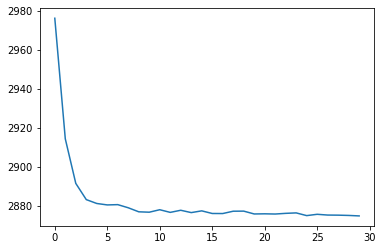

In [48]:
plot_mse_epoch(train_loss_super_lstm,epochs)

In [49]:
test_loss_super_lstm.cpu().detach().numpy()

array(3060.3823, dtype=float32)

#### ATTENTION 

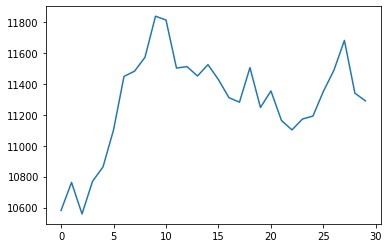

In [50]:
plot_mse_epoch(train_loss_super_attn, epochs)

In [51]:
test_loss_super_attn.cpu().detach().numpy()

array(20618.32, dtype=float32)

### Co-Training

In [52]:
total_dict

{'train_loss_total_lstm': array([2978.12402344, 3035.97949219, 3285.20703125, 3410.75390625,
        3411.74462891, 3519.93115234, 3593.19018555, 3618.31665039,
        3767.17749023, 3875.65380859, 3982.74560547, 4025.08837891,
        3995.51147461, 4027.0637207 , 4099.24609375, 4135.57324219,
        4169.77246094, 4179.97363281, 4223.59912109, 4243.90966797,
        4279.46435547, 4308.07763672, 4303.52734375, 4309.53662109,
        4309.13330078, 4313.03125   , 4318.45800781, 4299.296875  ,
        4272.31103516, 4261.00488281]),
 'train_loss_total_attn': array([11436.31445312, 10844.80566406, 11043.00976562, 10365.38085938,
        10018.109375  , 10073.66308594,  9587.77929688,  9526.05957031,
         9484.875     ,  9454.88671875,  9147.12988281,  9112.8671875 ,
         9022.66992188,  8865.00195312,  8510.18554688,  8350.55664062,
         8523.43554688,  8241.03515625,  8287.17773438,  8005.14550781,
         7915.15185547,  7836.92089844,  7806.47607422,  7647.41308594,
  

In [53]:
if not os.path.exists(f'saved_losses/{now}'):
    os.makedirs(f'saved_losses/{now}')

In [54]:
np.save(f'./saved_losses/{now}/super_train_loss_lstm',train_loss_super_lstm)
np.save(f'./saved_losses/{now}/super_train_loss_super_attn',train_loss_super_attn)

np.save(f'./saved_losses/{now}/co_train_loss_total_lstm',total_dict['train_loss_total_lstm'])
np.save(f'./saved_losses/{now}/co_train_loss_total_attn',total_dict['train_loss_total_attn'])
np.save(f'./saved_losses/{now}/co_test_lstm_total',total_dict['test_lstm_total'])
np.save(f'./saved_losses/{now}/co_test_attn_total',total_dict['test_attn_total'])

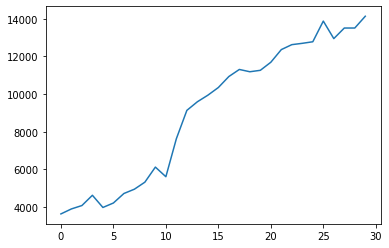

In [43]:
plot_mse_epoch(total_dict['train_loss_total_lstm'], epochs)

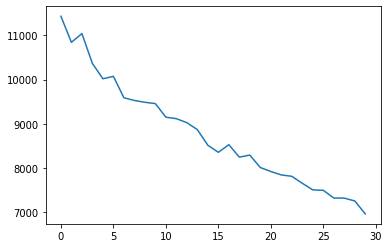

In [44]:
plot_mse_epoch(total_dict['train_loss_total_attn'], epochs)

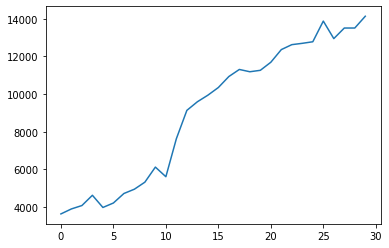

In [45]:
plot_mse_epoch(total_dict['test_lstm_total'], epochs)

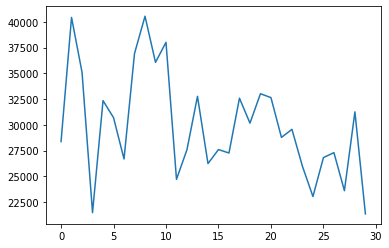

In [46]:
plot_mse_epoch(total_dict['test_attn_total'], epochs)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e3c63109-179d-4951-97a2-5a13ae332211' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

## Load Saved Models

### Co-Training Models 

In [37]:
model_lstm_co = LSTMGNN(GCLSTM, node_features=2, out_channels=nodes, K=2)
model_attn_co = AttentionGNN(A3TGCN, node_features=2, periods=1, out_channels=nodes)

model_lstm_co.load_state_dict(torch.load('/NAM/saved_models/23_33-19_06_22/model_lstm_co.pt'))
model_attn_co.load_state_dict(torch.load('/NAM/saved_models/23_33-19_06_22/model_attn_co.pt'))

<All keys matched successfully>

In [38]:
model_lstm_co

LSTMGNN(
  (tgnn): GCLSTM(
    (conv_i): ChebConv(207, 207, K=2, normalization=sym)
    (conv_f): ChebConv(207, 207, K=2, normalization=sym)
    (conv_c): ChebConv(207, 207, K=2, normalization=sym)
    (conv_o): ChebConv(207, 207, K=2, normalization=sym)
  )
  (linear): Linear(in_features=207, out_features=1, bias=True)
)

In [39]:
model_attn_co

AttentionGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 207)
      (linear_z): Linear(in_features=414, out_features=207, bias=True)
      (conv_r): GCNConv(2, 207)
      (linear_r): Linear(in_features=414, out_features=207, bias=True)
      (conv_h): GCNConv(2, 207)
      (linear_h): Linear(in_features=414, out_features=207, bias=True)
    )
  )
  (linear): Linear(in_features=207, out_features=1, bias=True)
)

###  Load Supervised Models

In [40]:
model_lstm_super = LSTMGNN(GCLSTM, node_features=2, out_channels=nodes, K=2)
model_attn_super = AttentionGNN(A3TGCN, node_features=2, periods=1, out_channels=nodes)

model_lstm_super.load_state_dict(torch.load('/NAM/saved_models/23_33-19_06_22/model_lstm_super.pt'))
model_attn_super.load_state_dict(torch.load('/NAM/saved_models/23_33-19_06_22/model_attn_super.pt'))

<All keys matched successfully>

In [41]:
print(model_lstm_super)

LSTMGNN(
  (tgnn): GCLSTM(
    (conv_i): ChebConv(207, 207, K=2, normalization=sym)
    (conv_f): ChebConv(207, 207, K=2, normalization=sym)
    (conv_c): ChebConv(207, 207, K=2, normalization=sym)
    (conv_o): ChebConv(207, 207, K=2, normalization=sym)
  )
  (linear): Linear(in_features=207, out_features=1, bias=True)
)


In [42]:
print(model_attn_super)

AttentionGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 207)
      (linear_z): Linear(in_features=414, out_features=207, bias=True)
      (conv_r): GCNConv(2, 207)
      (linear_r): Linear(in_features=414, out_features=207, bias=True)
      (conv_h): GCNConv(2, 207)
      (linear_h): Linear(in_features=414, out_features=207, bias=True)
    )
  )
  (linear): Linear(in_features=207, out_features=1, bias=True)
)


#### Load Model to GPU

In [52]:
model_attn_co.to(device)
model_lstm_co.to(device)
model_lstm_super.to(device)
model_attn_super.to(device)

AttentionGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 207)
      (linear_z): Linear(in_features=414, out_features=207, bias=True)
      (conv_r): GCNConv(2, 207)
      (linear_r): Linear(in_features=414, out_features=207, bias=True)
      (conv_h): GCNConv(2, 207)
      (linear_h): Linear(in_features=414, out_features=207, bias=True)
    )
  )
  (linear): Linear(in_features=207, out_features=1, bias=True)
)

## Evaluate on Train Set 

In [158]:
# Co-Training Validation Test
@torch.no_grad()
def validation_test_cotrain(model_lstm, model_a3t, input_data):
    # Put the models into Eval mode
    model_lstm.eval()
    model_a3t.eval()
    # Define and initialize Loss
    loss = MSELoss()
    loss_total = torch.zeros(len(list(input_data))).to(device)
    
    node = 69
    yhat_for_node = []
    # Generate Predictions
    for timestep, snapshot in enumerate(input_data):
        
        # Load data to gpu
        snapshot.x = snapshot.x.to(device)
        snapshot.y = snapshot.y.to(device)
        snapshot.edge_index = snapshot.edge_index.to(device)
        
        # Forward passes for a timestep
        model_lstm_yhat = model_lstm.forward(snapshot.x.reshape(-1, 2), snapshot.edge_index).reshape(-1)
        model_a3t_yhat = model_a3t.forward(snapshot.x, snapshot.edge_index).reshape(-1)
        
        yhat_cotrain = torch.div(torch.add(model_lstm_yhat, model_a3t_yhat), 2)
        
        yhat_for_node.append(yhat_cotrain[node].cpu().detach().numpy().item())
        
        loss_model = loss(yhat_cotrain[masked_nodes], snapshot.y[masked_nodes].reshape(-1))
        loss_total[timestep]=loss_model.item()
        
    return yhat_cotrain, yhat_for_node, loss_total

In [159]:
yhat_cotrain, yhat_for_node_cotrain, loss_total_cotrain = validation_test_cotrain(model_lstm_co, model_attn_co, rest_dataset)


In [138]:
yhat_cotrain.cpu().detach().numpy()

array([ 0.48657998,  0.4559071 ,  0.47998554,  0.28064907, -0.37215987,
        0.23977533,  0.31004483,  0.46753204,  0.4471499 ,  0.48200032,
        0.45034817,  0.47217038,  0.47217038,  0.45906693,  0.32455626,
        0.4771753 , -0.51293194,  0.4567161 ,  0.24206403,  0.47217038,
        0.48535347,  0.22972918,  0.3850431 ,  0.11647582,  0.4970447 ,
        0.4582651 ,  0.43670642,  0.45274454,  0.4970447 ,  0.4970447 ,
        0.17294583,  0.48657998,  0.49286407,  0.47292456,  0.4737534 ,
        0.24965096,  0.4058301 ,  0.48200032,  0.09374115,  0.44873458,
        0.49531385,  0.46904168,  0.4970447 ,  0.46904168,  0.46674907,
        0.49033868,  0.4479425 ,  0.4511377 ,  0.02786803,  0.4629164 ,
        0.4172209 ,  0.4172209 ,  0.49415475,  0.395933  ,  0.45906693,
        0.44553208,  0.17939335,  0.4431212 ,  0.40051648,  0.44071364,
        0.4629164 ,  0.4737534 ,  0.4241456 ,  0.49033868,  0.18735543,
        0.0756892 ,  0.48657998,  0.49033868,  0.47292456,  0.48

In [139]:
yhat_for_node

[tensor(0.3197, device='cuda:0'),
 tensor(0.3359, device='cuda:0'),
 tensor(0.3114, device='cuda:0'),
 tensor(0.3324, device='cuda:0'),
 tensor(0.3563, device='cuda:0'),
 tensor(0.1713, device='cuda:0'),
 tensor(0.3685, device='cuda:0'),
 tensor(0.3722, device='cuda:0'),
 tensor(0.3760, device='cuda:0'),
 tensor(0.3324, device='cuda:0'),
 tensor(0.3739, device='cuda:0'),
 tensor(0.3840, device='cuda:0'),
 tensor(0.4289, device='cuda:0'),
 tensor(0.3867, device='cuda:0'),
 tensor(0.3941, device='cuda:0'),
 tensor(0.4134, device='cuda:0'),
 tensor(0.3356, device='cuda:0'),
 tensor(0.4233, device='cuda:0'),
 tensor(0.4045, device='cuda:0'),
 tensor(0.4316, device='cuda:0'),
 tensor(0.4245, device='cuda:0'),
 tensor(0.4141, device='cuda:0'),
 tensor(0.4386, device='cuda:0'),
 tensor(0.4316, device='cuda:0'),
 tensor(0.4366, device='cuda:0'),
 tensor(0.4338, device='cuda:0'),
 tensor(0.4465, device='cuda:0'),
 tensor(0.4503, device='cuda:0'),
 tensor(0.4224, device='cuda:0'),
 tensor(0.4162

In [140]:
torch.sum(loss_total_cotrain)

tensor(6456.2256, device='cuda:0')

In [160]:
# Supervised Validation Test
@torch.no_grad()
def supervised_test_cotrain(model, input_data,reshape=False):
    # Put the models into Eval mode
    model.eval()
    # Define and initialize Loss
    loss = MSELoss()
    loss_total = torch.zeros(len(list(input_data))).to(device)
    
    node = 69
    yhat_for_node = []
    # Generate Predictions
    for timestep, snapshot in enumerate(input_data):

        # Load data to gpu
        snapshot.x = snapshot.x.to(device)
        snapshot.y = snapshot.y.to(device)
        snapshot.edge_index = snapshot.edge_index.to(device)
        
        # Forward passes for a timestep
        if reshape:
            yhat = model.forward(snapshot.x.reshape(-1, 2), snapshot.edge_index).reshape(-1)
        else:
            yhat = model.forward(snapshot.x, snapshot.edge_index).reshape(-1)

        yhat_for_node.append(yhat[node].cpu().detach().numpy().item())

        loss_model = loss(yhat[masked_nodes], snapshot.y[masked_nodes].reshape(-1))
        loss_total[timestep]=loss_model.item()

    return yhat, yhat_for_node, loss_total

In [161]:
yhat_lstm, yhat_for_node_lstm, loss_total_lstm = supervised_test_cotrain(model_lstm_super,rest_dataset,reshape=True)


In [133]:
yhat_for_node_lstm

[0.29350918531417847,
 0.33470577001571655,
 0.2608993649482727,
 0.3206208646297455,
 0.3744479715824127,
 0.3079264163970947,
 0.3953710198402405,
 0.40097522735595703,
 0.4068204164505005,
 0.3045527935028076,
 0.39926767349243164,
 0.4188804626464844,
 0.5372140407562256,
 0.42181897163391113,
 0.4403443932533264,
 0.4978920817375183,
 0.2951839566230774,
 0.5197622776031494,
 0.47805118560791016,
 0.5563969016075134,
 0.5355985164642334,
 0.5135148167610168,
 0.5901899933815002,
 0.5684207081794739,
 0.5908579230308533,
 0.5794271230697632,
 0.6080455183982849,
 0.6136821508407593,
 0.5387403964996338,
 0.5232204794883728,
 0.5669739842414856,
 0.5736430883407593,
 0.6137139201164246,
 0.5332966446876526,
 0.5302968621253967,
 0.5298901796340942,
 0.5058836340904236,
 0.5875234007835388,
 0.5258610248565674,
 0.5509687662124634,
 0.6116092205047607,
 0.5505291819572449,
 0.40639549493789673,
 0.48111408948898315,
 0.46653419733047485,
 0.6082238554954529,
 0.4414416253566742,
 0.5

In [135]:
torch.sum(loss_total_lstm)

tensor(873.7417, device='cuda:0')

In [134]:
yhat_attn, yhat_for_node_attn, loss_total_attn = supervised_test_cotrain(model_attn_super,rest_dataset)


In [91]:
torch.sum(loss_total_attn)

tensor(7584.6230, device='cuda:0')

## Load npy saved files

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
epochs=30

In [7]:
!pwd

/NAM


In [8]:
saved_losses_dir = '/NAM/saved_losses/23_33-19_06_22'
print("Directory exists:",os.path.isdir(saved_losses_dir))
os.path.abspath(saved_losses_dir)

Directory exists: True


'/NAM/saved_losses/23_33-19_06_22'

In [9]:
train_loss_total_lstm=np.load(saved_losses_dir+"/co_test_lstm_total.npy")

In [10]:
train_loss_total_attn=np.load(saved_losses_dir+"/co_train_loss_total_attn.npy")

In [11]:
test_lstm_total=np.load(saved_losses_dir+"/co_test_lstm_total.npy")

In [12]:
test_attn_total=np.load(saved_losses_dir+"/co_test_attn_total.npy")

In [13]:
train_loss_super_lstm=np.load(saved_losses_dir+"/super_train_loss_lstm.npy")
train_loss_super_attn=np.load(saved_losses_dir+"/super_train_loss_super_attn.npy")

In [14]:
total_dict={'train_loss_total_lstm':train_loss_total_lstm, 
            'train_loss_total_attn':train_loss_total_attn,
            'test_lstm_total':test_lstm_total,
            'test_attn_total':test_attn_total}

In [25]:
train_loss_total_lstm[-1]+train_loss_total_lstm[-1]//2

21199.044921875

In [26]:
train_loss_super_lstm

array([2976.07836914, 2914.30908203, 2891.47290039, 2883.16308594,
       2881.18017578, 2880.43920898, 2880.5871582 , 2878.97998047,
       2876.91455078, 2876.71264648, 2877.98144531, 2876.62133789,
       2877.70556641, 2876.5078125 , 2877.39941406, 2876.0546875 ,
       2876.02587891, 2877.21850586, 2877.26196289, 2875.80834961,
       2875.88574219, 2875.77734375, 2876.12353516, 2876.35327148,
       2874.96337891, 2875.63769531, 2875.24804688, 2875.1965332 ,
       2875.05664062, 2874.80908203])

In [27]:
train_loss_super_attn

array([10580.890625  , 10762.39550781, 10558.45898438, 10769.7734375 ,
       10863.21484375, 11102.49023438, 11449.87890625, 11483.39550781,
       11573.94824219, 11839.7734375 , 11815.5234375 , 11503.68359375,
       11513.4296875 , 11452.6171875 , 11525.99023438, 11428.7109375 ,
       11311.81835938, 11282.71289062, 11506.76953125, 11248.59277344,
       11355.48828125, 11164.37207031, 11102.8671875 , 11173.3203125 ,
       11192.63769531, 11353.18164062, 11489.75390625, 11683.25976562,
       11341.21679688, 11291.02539062])

### Plot Loss Figures

In [182]:
def multi_plot(y,n,name):
    epoch_list = [i for i in range(n)]
    for i,l in y:
        plt.plot(epoch_list, i, label=l)
    plt.xlabel("Timestep")
    plt.ylabel("Mph")
    leg = plt.legend(loc='lower right')
    plt.title(name)
    plt.savefig('saved_figs/'+name+'.eps', format='eps')

In [76]:
# EPS Plot saving method
def plot_save(y,n,name):
    epoch_list = [i for i in range(n)]
    plt.plot(epoch_list, y)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.title(name)
#     plt.savefig('saved_figs/'+name+'.eps', format='eps')

### Plot Figures from Validation 

In [154]:
true_values=[]
for timestep, snapshot in enumerate(rest_dataset):
    true_values.append(snapshot.y[69].detach().numpy().item())
len(true_values)

6855

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


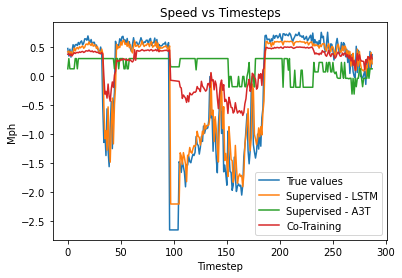

In [183]:
multi_plot([
            (true_values[:288],'True values'),
            (yhat_for_node_lstm[:288],'Supervised - LSTM'),
                (yhat_for_node_attn[:288],'Supervised - A3T'),
(yhat_for_node_cotrain[:288],'Co-Training')],
           288,'Speed vs Timesteps')


### Plot Figures from Train

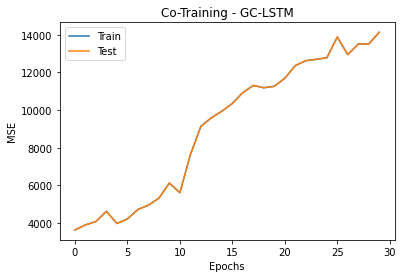

In [34]:
multi_plot([(train_loss_total_lstm, 'Train'),(test_lstm_total,'Test')],epochs,'Co-Training - GC-LSTM')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


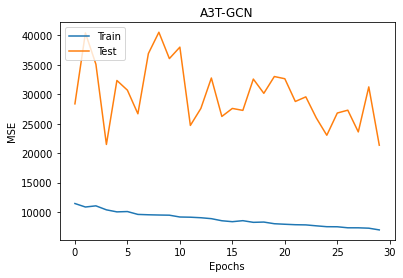

In [41]:
multi_plot([(train_loss_total_attn,'Train'),(test_attn_total,'Test')],epochs,'A3T-GCN')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


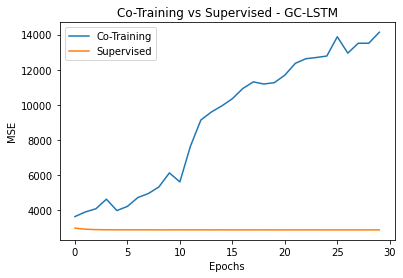

In [46]:
multi_plot([(train_loss_total_lstm,'Co-Training'),(train_loss_super_lstm,'Supervised')],epochs,"Co-Training vs Supervised - GC-LSTM")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


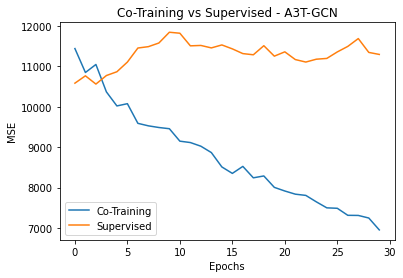

In [50]:
multi_plot([(train_loss_total_attn,'Co-Training'),(train_loss_super_attn,'Supervised')],epochs,"Co-Training vs Supervised - A3T-GCN")

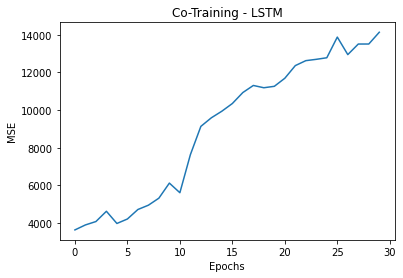

In [25]:
plot_save(train_loss_total_lstm,epochs,'Co-Training - GC-LSTM')